# Goole Colab
Check this tutorial on [Google Colab](https://colab.research.google.com/github/simone-mastrogiovanni/GW_teaching_material/blob/master/GW_cosmology/estimate_the_Hubble_constant_galaxy_catalogs.ipynb) 

## Installation (execute only if running on a cloud platform!)¶

In [1]:
# Uncomment this line if you are on Colab or Binder
#! pip install healpy
#! pip install h5py

In [2]:
import os
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import h5py
import healpy as hp

# Estimate the Hubble constant with GW170817

In this tutorial we will estimate the Hubble constant from GW170817.

## Review of the statistical method

The Hubble constant posterior (see Notes from the lectures) is

$$p(H_0|{\rm GW170817}) \propto p(H_0) \frac{\int_0^{z_{\rm max}} \frac{p(d_L(z,H_0)|\rm{GW170817})}{\pi(d_L(z,H_0))} p(z_{\rm EM}|z) p(z) dz}{\int p_{\rm det}(z,H_0) p(z) dz}$$.

In the above Eq.:

* $p(H_0)$ is a prior that we can take as Uniform
* $\frac{p(d_L(z,H_0)|\rm{GW170817})}{\pi(d_L(z,H_0))}$ is the luminosity distance posterior of the GW divided by its prior. Note that this is evaluated using the redhisft.
* $p(z_{\rm EM}|z)$ Is the measure of the redshift from an EM counterpart.
* $p(z)$ is a prior on redshift, we can take it as $p(z) \propto z^2$ at low redshift.
* $p_{\rm det}(z,H_0)$ Is a detection probability. 

In the following we are going to put these pieces all together

## Review of Cosmology

Being GW170817 a close-by event, we will work in the "linear" cosmology approximation, e.g.

$$d_L=\frac{cz}{H_0}$$

## GW170817 and its luminosity distance distribution

In [3]:
def z2dl(z,H0):
    '''This function returns the luminosity distance in Mpc given a redshift and Hubble constant
    '''
    return 299792.458*z/H0

In [4]:
!wget https://dcc.ligo.org/public/0157/P1800370/005/GW170817_GWTC-1.hdf5
posterior_EV=h5py.File('GW170817_GWTC-1.hdf5')
os.remove('GW170817_GWTC-1.hdf5')

--2024-06-30 12:20:00--  https://dcc.ligo.org/public/0157/P1800370/005/GW170817_GWTC-1.hdf5
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2520704 (2,4M)
Saving to: ‘GW170817_GWTC-1.hdf5’

GW170817_GWTC-1.hdf 100%[===================>]   2,40M   184KB/s    in 28s     

2024-06-30 12:20:35 (86,5 KB/s) - ‘GW170817_GWTC-1.hdf5’ saved [2520704/2520704]



Text(0, 0.5, '$\\frac{p(d_L(z,H_0)|\\rm{GW170817})}{\\pi(d_L(z,H_0))}$')

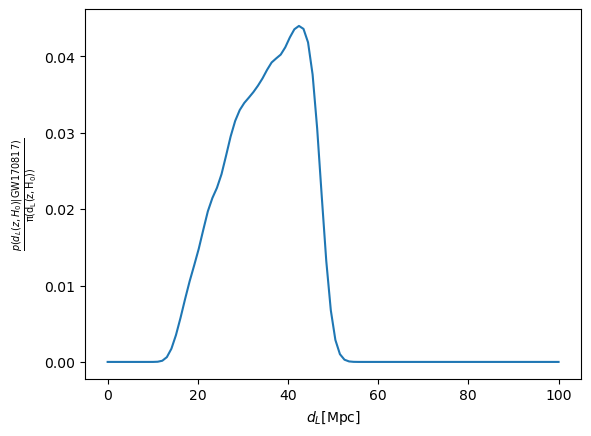

In [5]:
# We extract the luminosity distance in Mpc
dl_samples=posterior_EV['IMRPhenomPv2NRT_lowSpin_posterior']['luminosity_distance_Mpc']

# Creates the distance posterior estimator and removes the prior. This is the term in the numerator of the Hubble constant posterior
GW170817_interp=gaussian_kde(dl_samples,weights=dl_samples**-2)

dl_array=np.linspace(0,100,100)

plt.plot(dl_array,GW170817_interp(dl_array))
plt.xlabel(r'$d_L$[Mpc]')
plt.ylabel(r'$\frac{p(d_L(z,H_0)|\rm{GW170817})}{\pi(d_L(z,H_0))}$')

Text(0, 0.5, '$\\frac{p(d_L(z,H_0)|\\rm{GW170817})}{\\pi(d_L(z,H_0))}$')

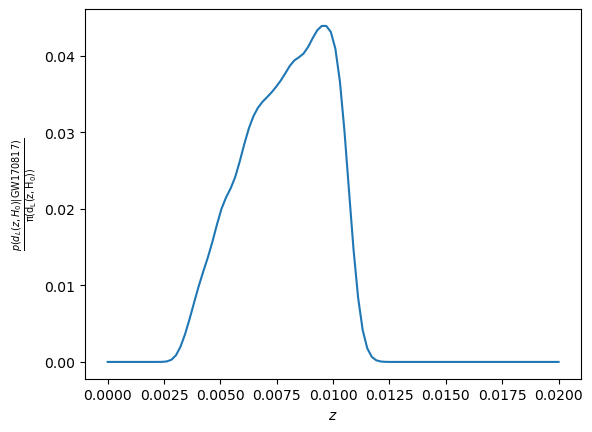

In [6]:
z_array=np.linspace(0,0.02,100)

# Same but in redshift
plt.plot(z_array,GW170817_interp(z2dl(z_array,H0=67.7)))
plt.xlabel(r'$z$')
plt.ylabel(r'$\frac{p(d_L(z,H_0)|\rm{GW170817})}{\pi(d_L(z,H_0))}$')

## The selection bias

For this analysis, we will approximate the selection bias with an easy assumption. We will assume that we are able to detect all the GWs *AND* EM counterparts from BNSs  that merge within a luminosity distance of $100$ Mpc.  Note that this is an oversimplistic assumption as the range at which we are able to detect also depends on the binary inclination. To calculate the selection bias we also need a $p(z)$ that we take normalized up to $z_{\rm max}=0.5$

In [7]:
def pdet(distance,dlim=100):
    '''This function returns the detection probability given a luminosity distance and redshift range
    '''
    toret=np.ones_like(distance)
    toret[distance>dlim]=0.
    return toret

def pz(z,zmax=0.5):
    '''This function returns the prior in redshift p(z) normalized to the maximum redshift zmax
    '''
    return np.power(z,2.)/(np.power(zmax,3.)/3.)

Text(0, 0.5, 'Detection probability')

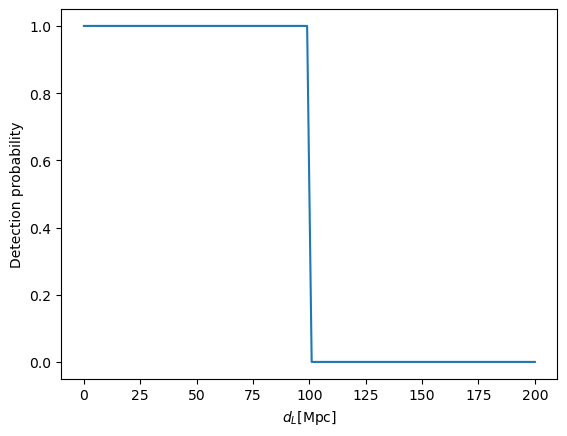

In [8]:
dl_array=np.linspace(0,200,100)
plt.plot(dl_array,pdet(dl_array))
plt.xlabel(r'$d_L$[Mpc]')
plt.ylabel(r'Detection probability')

CHECK-The prior integral is:  1.0000510152025304


Text(0, 0.5, '$p(z)$')

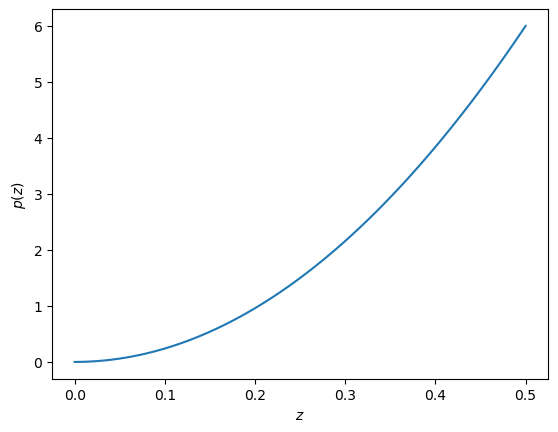

In [9]:
z_array=np.linspace(0,0.5,100)
plt.plot(z_array,pz(z_array))
print('CHECK-The prior integral is: ',np.trapz(pz(z_array),z_array))
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z)$')

Text(0, 0.5, 'Selection bias')

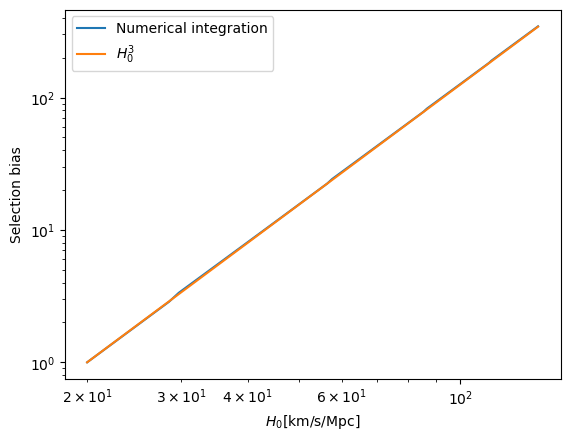

In [10]:
H0_array=np.linspace(20,140,100)
selection_bias=np.zeros_like(H0_array)

for i,H0 in enumerate(H0_array):
    z_integrator=np.linspace(0,0.5,5000)
    selection_bias[i]=np.trapz(pdet(z2dl(z_integrator,H0=H0))*pz(z_integrator),z_integrator)
plt.loglog(H0_array,selection_bias/selection_bias[0],label=r'Numerical integration')
plt.loglog(H0_array,(H0_array/H0_array[0])**3,label=r'$H_0^3$')
plt.legend()
plt.xlabel(r'$H_0$[km/s/Mpc]')
plt.ylabel(r'Selection bias')

## GW170817 as a Bright standard siren

The host galaxy of GW170817 was NGC4993. This allowed us to estimate the redshift of the GW event. When we perfectly measure the redshift, the EM part of the probability can be written as a delta function

$$p(z_{\rm EM}|z)=\delta(z_{\rm EM}-z)$$

and the integration can be done analytically. The Hubble constant posterior is simply given by

$$p(H_0|{\rm GW170817}) \propto p(H_0) \frac{ \frac{p(d_L(z_{\rm EM},H_0)|\rm{GW170817})}{\pi(d_L(z_{\rm EM},H_0))}}{\int p_{\rm det}(z,H_0) p(z) dz}$$.


Text(0, 0.5, 'Selection bias')

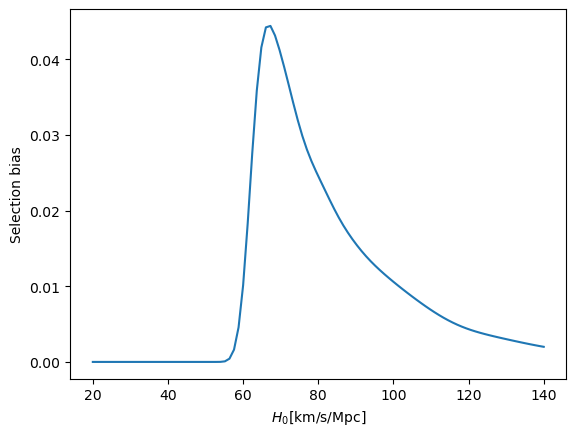

In [11]:
z_EM=0.0099 # Redshift of NGC4993

H0_array=np.linspace(20,140,100)
posterior=np.zeros_like(H0_array)
for i,H0 in enumerate(H0_array):
    posterior[i]=GW170817_interp(z2dl(z_EM,H0=H0))/(H0**3)
posterior/=np.trapz(posterior)
plt.plot(H0_array,posterior)
plt.xlabel(r'$H_0$[km/s/Mpc]')
plt.ylabel(r'Selection bias')

**Challenge:**

* Find the median and 68% symmetric credible intervals of the Hubble constant posterior. 
* Calculate the Hubble constant posterior using another sample set for the luminosity distance. Use `IMRPhenomPv2NRT_highSpin_posterior`. Is the Hubble constant measure less or more precise? Can you tell why?

## GW170817 as a Dark standard siren

In the case that we are not able to identify a galaxy for our GW event, we can still make use of galaxy catalogs to estimate the Hubble constant. Here I will make a very simplified example for this type of analysis.

We assume that:

* We have a good accuracy on the sky location of the source. By looking at the galaxy catalog, I can identify all the galaxies listed at the source sky position. If all the galaxies have the same probability of emitting a GW event, the EM likelihood is

$$p(\vec{z}_{\rm EM}|z)=\frac{1}{N_{\rm gal}}\sum_i^{N_{\rm gal}} \delta(z^i_{\rm EM}-z)$$,

where the index $i$ runs over all the galaxies at the same sky location of GW170817

* And that the selection bias is dominated by the GW selection function (this is not the case currently). With this hypothesis, I can take the selection bias equal to the one of the previous case.

With these two assumptions, calculating the Hubble constant posterior consists simply in applying the `bright siren procedure` for each host galaxy and then provide an average result

In [12]:
nside=32 # Resolution for the skymap
ra,dec=posterior_EV['IMRPhenomPv2NRT_lowSpin_posterior']['right_ascension'][0],posterior_EV['IMRPhenomPv2NRT_lowSpin_posterior']['declination'][0]
GW170817_pixel=hp.ang2pix(nside,np.pi/2+dec,ra) # Find to what pixel GW170817 corresponds
print('GW170817 is in the pixel {:d}'.format(GW170817_pixel))
print('The skymap resolution is {:f} deg2'.format(hp.nside2pixarea(nside,degrees=True)))

GW170817 is in the pixel 3718
The skymap resolution is 3.357175 deg2


In [13]:
# Uncomment this line if you are on Colab  or Binder
# ! wget https://github.com/simone-mastrogiovanni/MaNiTou2022/blob/master/DA_handson/glade_reduced.txt?raw=true 
# ! mv glade_reduced.txt?raw=true glade_reduced.txt

data=np.genfromtxt('glade_reduced.txt') # We load a reduced version of the glade Galaxy catalog

In [14]:
galaxy_indices=hp.ang2pix(nside,np.pi/2+data[:,2],data[:,1]) # We find the pixel of each galaxy
idx_gal=np.where(galaxy_indices==GW170817_pixel)[0] # We find all the galaxies falling in the GW170817 pixel

# We count the galaxies in each pixel to make a plot
countmap=np.zeros(hp.nside2npix(nside))
for i in range(len(countmap)):
    countmap[i]=len(np.where(galaxy_indices==i)[0])

/tmp/ipykernel_11679/2908664768.py:4: RuntimeWarning: divide by zero encountered in log10
  np.log10(countmap),


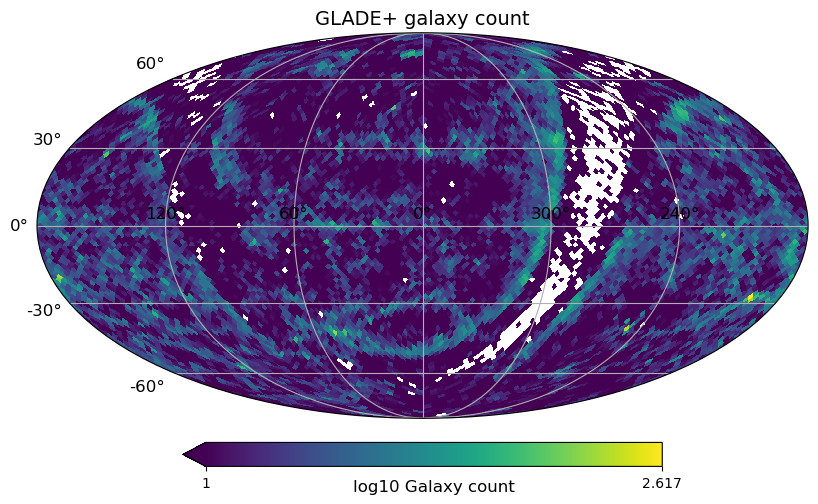

In [15]:
from healpy.newvisufunc import projview, newprojplot

projview(
    np.log10(countmap),
    graticule=True,
    graticule_labels=True,
    title="GLADE+ galaxy count",
    unit="log10 Galaxy count",
    min=1
);

Text(0, 0.5, 'Galaxy count')

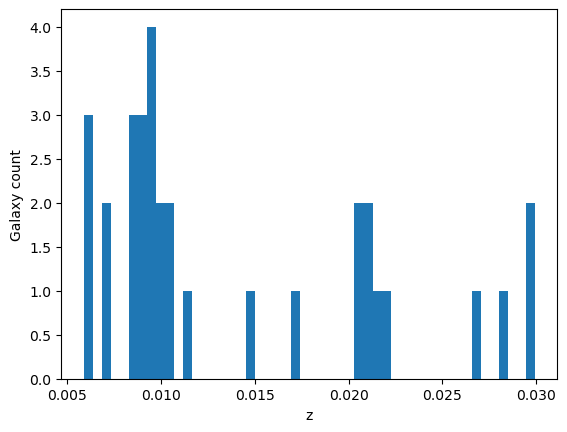

In [16]:
z_gal_pixel=data[idx_gal,0] # We save all the galaxies in GW170817 location
plt.hist(z_gal_pixel,bins=50)
plt.xlabel('z')
plt.ylabel('Galaxy count') # We hisogram them


Text(0, 0.5, 'Selection bias')

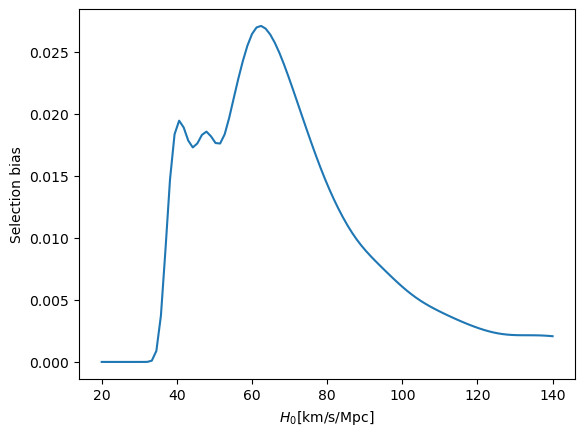

In [17]:
# We calculate the H0 for each galaxy in the sky location of GW170817
H0_array=np.linspace(20,140,100)
posterior=np.zeros_like(H0_array)
for i,H0 in enumerate(H0_array):
    for z in z_gal_pixel:
        posterior[i]+=GW170817_interp(z2dl(z,H0=H0))/(H0**3)
posterior/=np.trapz(posterior)
plt.plot(H0_array,posterior)
plt.xlabel(r'$H_0$[km/s/Mpc]')
plt.ylabel(r'Selection bias')

**Challenge**:

In the above example, we have neglected the fact that GW170817 has a sky localization uncertainty of 20deg^2. Knowing that, can you generate an Hubble constant measure taking into account this uncertainty?